## Segmentation of Cell Nuclei Using Otsu Thresholding

### 1. Introduction

Accurate segmentation of cell nuclei in fluorescence microscopy images is an essential step in many biomedical image analysis pipelines. Manual segmentation is impractical for large datasets, as it is time-consuming, subjective, and non-reproducible. Automated thresholding methods such as **Otsu’s method** provide an efficient way to segment cell nuclei by automatically selecting an intensity threshold that separates foreground (nuclei) from background.

In this project, we implemented and evaluated **global** and **local Otsu thresholding methods** for cell nuclei segmentation, as required by Project 3 of the Biomedical Image Analysis topic. Furthermore, we applied these methods to three different microscopy datasets:

- **N2DH-GOWT1**: GFP-labeled mouse embryonic stem cells.
- **N2DL-HeLa**: H2B-GFP-labeled HeLa cells.
- **NIH3T3**: Mouse fibroblast cells with challenging bright artifacts.

### 2. Objectives

The main objectives of our work were:

- To implement global Otsu thresholding for cell nuclei segmentation.
- To extend the implementation to local Otsu thresholding using a sliding window approach.
- To quantitatively evaluate the segmentation performance using the Dice coefficient against manually annotated ground-truth masks.
- To verify our implementations by comparing them to the `scikit-image` package.
- To investigate the application of Multi-Otsu thresholding on the NIH3T3 dataset to reduce the effect of extreme brightness artifacts (“flashes”).

### 3. Methods

- **Data Loading & Visualization**: We loaded and visualized representative images and ground truths from each dataset.
- **Thresholding**:
  - *Global Otsu*: Applied one threshold for the entire image.
  - *Local Otsu*: Computed thresholds within sliding windows to handle local variations in illumination.
  - *Multi-Otsu*: Applied multi-level thresholding to classify regions and suppress bright artifacts.
- **Evaluation**: Segmentation results were compared with ground-truth masks using the Dice score.
- **Performance Comparison**: We compared our local Otsu implementation with `scikit-image`’s `threshold_local()` for time efficiency.
- **Visualization & Analysis**: We plotted side-by-side image results and scatterplots to compare Dice scores across methods.

### 4. Notebook Structure

The notebook is organized as follows:

1. **Environment Setup**: Configuration for reproducibility and importing necessary modules.
2. **Loading Images & Ground Truth**: Reading representative images and masks from all datasets.
3. **Global and Local Thresholding**: Applying both our implementations and package methods.
4. **Dice Score Computation**: Calculating scores for quantitative assessment.
5. **Extended Analysis with Multi-Otsu**: Addressing artifacts in NIH3T3 with multi-thresholding.
6. **Results & Visualization**: Presenting outcomes using comparative plots.
7. **Conclusion**: Summarizing findings and practical insights.


## 1. Environment Setup

In this section, we configure the environment to ensure that our custom Python modules can be imported from anywhere in the notebook. By dynamically setting the project root and adding it to the Python path, we guarantee reproducibility and avoid path-related import errors. This setup is essential for maintaining a clean, modular, and portable project structure.

In [ ]:
import os
import sys

# Set the project root so we can import our custom modules from anywhere in the notebook
script_dir = os.getcwd()
project_root = os.path.abspath(script_dir)

if project_root not in sys.path:
    sys.path.insert(0, project_root)

## 2. Loading Images & Ground Truth

To perform a meaningful evaluation of our segmentation algorithms, it is essential to work with representative images from each of the three datasets provided: GOWT1, HeLa, and NIH3T3. This section demonstrates how we load and visualize both the raw images and their corresponding manually segmented ground truth masks.

**Loading and Visualizing Raw Images**

First, we use the custom utility `find_and_load_image` to locate and load representative grayscale images from each dataset. By plotting these side by side, we gain a visual overview of the differences in appearance and image quality between the datasets, which is critical for understanding the challenges of automated segmentation.

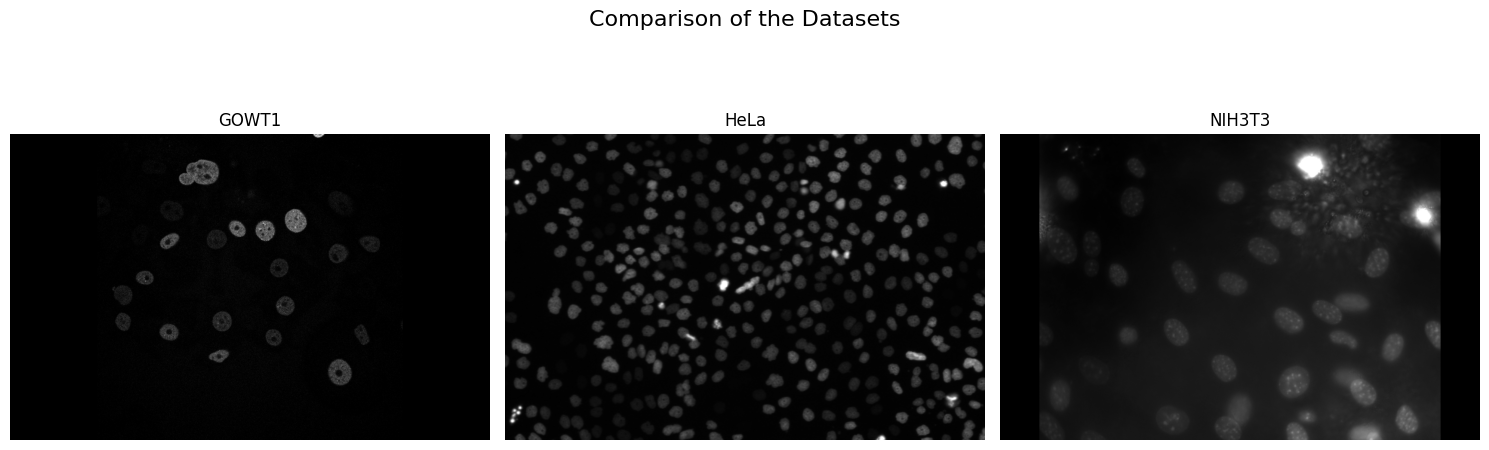

In [121]:
from src.find_image import find_and_load_image

img_gowt1 = find_and_load_image("t01.tif")
img_hela = find_and_load_image("t75.tif")
img_nih3t3 = find_and_load_image("dna-33.png")


from src.show_imgs import plot_images_fixed_size

images_img = [img_gowt1, img_hela, img_nih3t3]
titles_img = ["GOWT1", "HeLa", "NIH3T3"]

plot_images_fixed_size(images_img, titles=titles_img, main_title="Comparison of the Datasets")

**Loading and Visualizing Ground Truth Masks**

Next, we load the corresponding ground truth masks for the previously loaded images. These masks represent the expert-annotated segmentation of the cell nuclei and serve as the reference for evaluating our segmentation methods. Plotting the masks alongside the original images provides an immediate qualitative impression of the segmentation targets in each dataset.

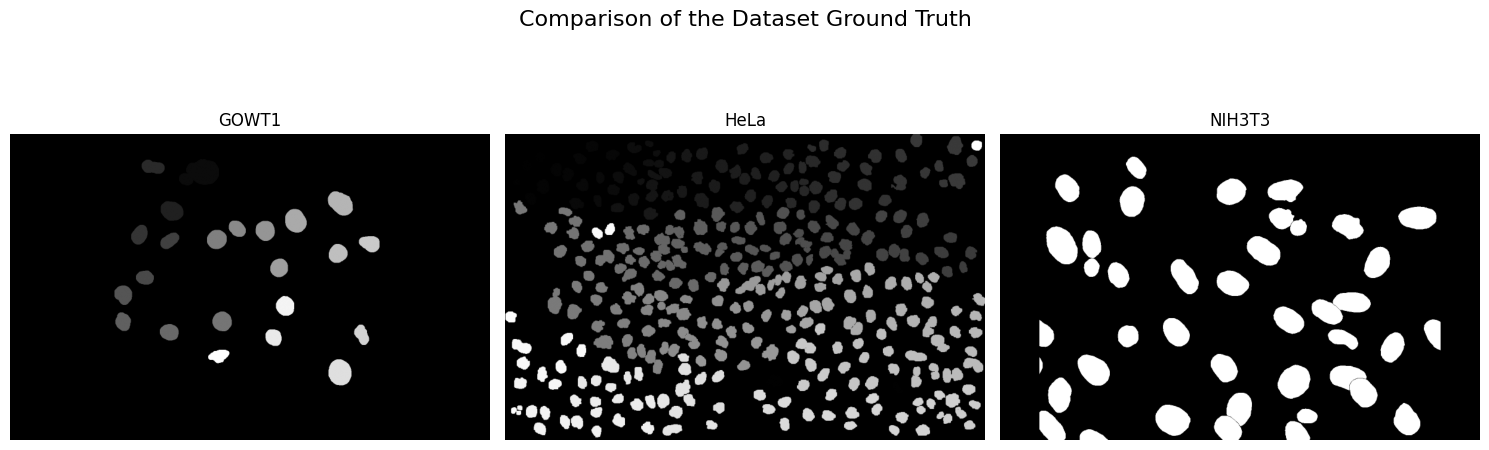

In [122]:
gt_gowt1 = find_and_load_image("man_seg01.tif")
gt_hela = find_and_load_image("man_seg75.tif")
gt_nih3t3 = find_and_load_image("33.png")


images_gt = [gt_gowt1, gt_hela, gt_nih3t3]
titles_gt = ["GOWT1", "HeLa", "NIH3T3"]

plot_images_fixed_size(images_gt, titles = titles_gt, main_title = "Comparison of the Dataset Ground Truth")

## 3. Global and Local Thresholding

In this section, we apply both our own implementations and standard package methods for global and local thresholding, key techniques for segmenting cell nuclei based on intensity differences.

**Global Otsu Thresholding (Our Implementation)**

We first apply our own implementation of Otsu’s global thresholding algorithm (`otsu_threshold_skimage_like`) on a representative GOWT1 image. This method automatically finds an optimal global threshold value that separates foreground (cell nuclei) from background based on maximizing inter-class variance in the grayscale histogram. The result is then compared against the ground truth.

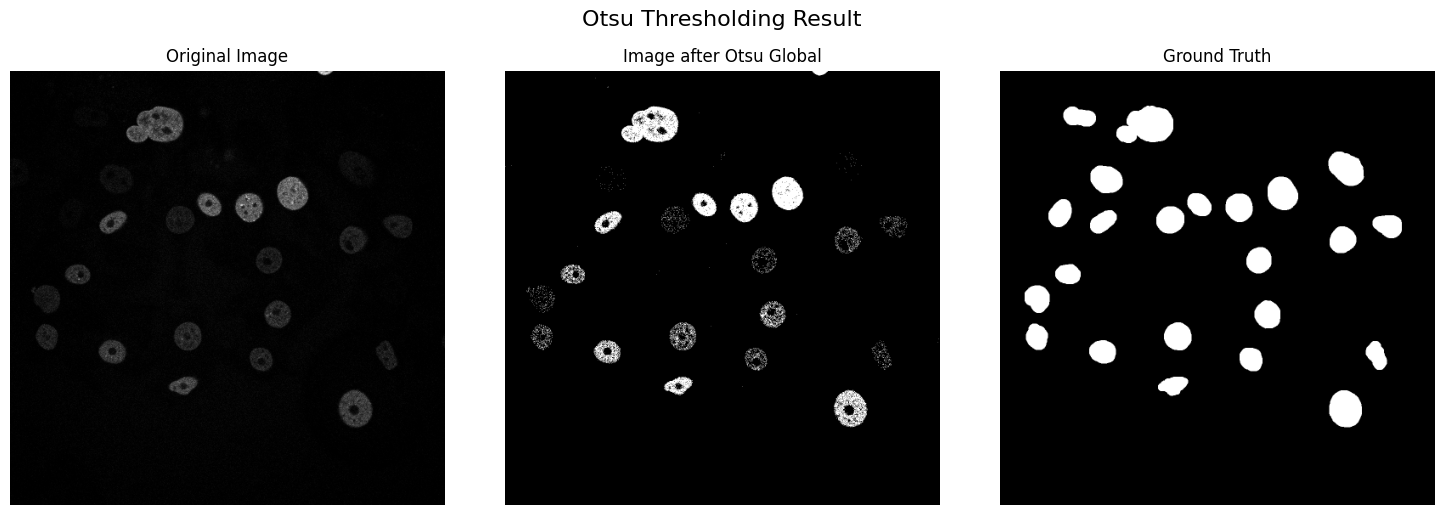

In [123]:
from src.Complete_Otsu_Global import otsu_threshold_skimage_like

threshold = otsu_threshold_skimage_like(img_gowt1)
img_gowt1_otsu_global = (img_gowt1 > threshold).astype(int)


plot_images_fixed_size(
    images=[img_gowt1, img_gowt1_otsu_global, (gt_gowt1 > 0).astype(int)],
    titles=["Original Image", "Image after Otsu Global", "Ground Truth"],
    main_title="Otsu Thresholding Result"
)

**Local Otsu Thresholding (Our Implementation)**

To handle images with non-uniform illumination, we extend Otsu’s method to a local variant using our own `local_otsu` implementation. This technique calculates a local threshold for each pixel within a sliding window, resulting in better segmentation performance in challenging images with shading artifacts or heterogeneous lighting.

**Important Note:** This implementation is computationally intensive and takes a long time to run on high-resolution images. Therefore, it may not be practical for quick notebook execution or large-scale datasets.

In [124]:
# takes very long

from src.Otsu_Local import local_otsu

thresholds_local = local_otsu(img_gowt1, radius = 15)
img_gowt1_otsu_local = (img_gowt1 > thresholds_local).astype(int)


plot_images_fixed_size(
    images=[img_gowt1, img_gowt1_otsu_local],
    titles=["Original Image", "Image after Otsu Local"],
    main_title="Local Otsu Thresholding Result\n(Radius = 15)"
)

Processing row 1/1024...
Processing row 51/1024...
Processing row 101/1024...
Processing row 151/1024...
Processing row 201/1024...
Processing row 251/1024...
Processing row 301/1024...
Processing row 351/1024...
Processing row 401/1024...
Processing row 451/1024...
Processing row 501/1024...
Processing row 551/1024...
Processing row 601/1024...


KeyboardInterrupt: 

**Local Otsu Thresholding (Package Method for Efficiency)**

For faster prototyping and visualization, we provide an alternative using the `threshold_local` function from the `skimage` library. While this method does not implement Otsu's local thresholding but a local mean threshold, it produces comparable segmentation results much faster. 

**Caution:** You should only execute either the custom local implementation (slow) or the package-based method (fast) — not both — because both define the same variable `img_gowt1_otsu_local`, which can cause conflicts during notebook execution.

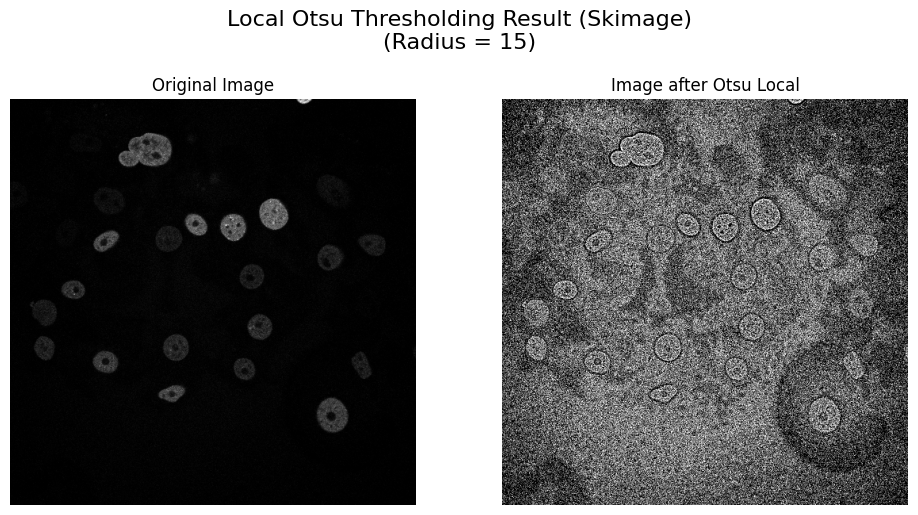

In [ ]:
# Package Otsu Local for visualisation for time efficiency
from skimage.filters import threshold_local

thresholds_local = threshold_local(img_gowt1, block_size=15, offset=0)
img_gowt1_otsu_local = (img_gowt1 > thresholds_local).astype(int)

plot_images_fixed_size(
    images=[img_gowt1, img_gowt1_otsu_local],
    titles=["Original Image", "Image after Otsu Local"],
    main_title="Local Otsu Thresholding Result (Skimage)\n(Radius = 15)"
)

## 4. Dice Score Computation

In this section, we compute Dice scores to quantitatively evaluate the performance of the global and local Otsu segmentation methods. The Dice coefficient measures the overlap between the predicted segmentation mask and the ground truth, providing a score between 0 (no overlap) and 1 (perfect match).

**Single Image Dice Score Computation:**

We begin by computing Dice scores for a single representative image (GOWT1) using both the global and local Otsu thresholding results. This provides an immediate indication of how each segmentation method performs on an example case before applying them across the full datasets.


In [ ]:

from src.Dice_Score import dice_score

dice_score_gowt1_global = dice_score(img_gowt1_otsu_global, gt_gowt1) 

dice_score_gowt1_local = dice_score(img_gowt1_otsu_local, gt_gowt1)


print("Dice Score Otsu Global:", dice_score_gowt1_global)
print("Dice Score Otsu Local:", dice_score_gowt1_local)

Dice Score Otsu Global: 0.5705017182130584
Dice Score Otsu Local: 0.1625783041495708


**Loading All Dataset Images:**

Next, we load all images and their corresponding ground truth masks from the three datasets (N2DH-GOWT1, N2DL-HeLa, NIH3T3). Access to the complete data is essential for a robust, dataset-wide evaluation of segmentation performance.

In [ ]:
# Imports from project-specific src/ directory
from src.imread_all import load_n2dh_gowt1_images, load_n2dl_hela_images, load_nih3t3_images


# Load images and ground-truth masks from the datasets
imgs_N2DH_GOWT1, gts_N2DH_GOWT1, img_paths_N2DH_GOWT1, gt_paths_N2DH_GOWT1 = load_n2dh_gowt1_images()
imgs_N2DL_HeLa, gts_N2DL_HeLa, img_paths_N2DL_HeLa, gt_paths_N2DL_HeLa = load_n2dl_hela_images()
imgs_NIH3T3, gts_NIH3T3, img_paths_NIH3T3, gt_paths_NIH3T3 = load_nih3t3_images()

**Global Otsu Dice Scores on All Datasets:**

We then calculate Dice scores across the entire datasets using our own global Otsu implementation. Using the calculate_dice_scores_global function we produces a distribution of Dice scores reflecting the performance of global thresholding on each dataset.

In [ ]:
from src.Dice_Score_comparison import calculate_dice_scores_global

# Compute Dice scores for each dataset
dice_all_gowt1_global = calculate_dice_scores_global(imgs_N2DH_GOWT1, gts_N2DH_GOWT1)
dice_all_hela_global = calculate_dice_scores_global(imgs_N2DL_HeLa, gts_N2DL_HeLa)
dice_all_nih_global = calculate_dice_scores_global(imgs_NIH3T3, gts_NIH3T3)

# Convert numpy floats to plain Python floats for clearer output
dice_all_gowt1_global = [float(score) for score in dice_all_gowt1_global]
dice_all_hela_global = [float(score) for score in dice_all_hela_global]
dice_all_nih_global = [float(score) for score in dice_all_nih_global]

# Print scores in a readable format
print("GOWT1_Scores_global =", list(dice_all_gowt1_global))
print("HeLa_Scores_global =", list(dice_all_hela_global))
print("NIH3T3_Scores_global =", list(dice_all_nih_global))

GOWT1_Scores_global = 0.5705017182130584, 0.32258217915948406, 0.568002229254991, 0.6271474725294504, 0.6502180828858916, 0.6615248976783192
HeLa_Scores_global = 0.6923060104510571, 0.649295517879001, 0.7760944676315427, 0.7761119912979735
NIH3T3_Scores_global = 0.9128436675562167, 0.8845252721173281, 0.8225479821936802, 0.758336987687637, 0.7528567225654604, 0.647632667167185, 0.6466958730507323, 0.7237186625334818, 0.03500481623642597, 0.46518566600901357, 0.0, 0.6762501531852865, 0.00026339009389856846, 0.5757554586315079, 0.6165448260228947, 0.07605520913993832, 0.07186834004262373, 0.7925039681767514


**Local Otsu Dice Scores on All Datasets (Our Implementation):**

To compare with the global approach, we also compute Dice scores across all images using our own implementation of local Otsu thresholding with the function calculate_dice_scores_local.
**Note**: This step can be very time-consuming due to the computational complexity of sliding-window thresholding. May consider using **Local Otsu Dice Scores on All Datasets (Package Implementation)**.


In [125]:
# takes very long
from src.Dice_Score_comparison import calculate_dice_scores_local

# Compute Dice scores for each dataset
dice_all_gowt1_local = calculate_dice_scores_local(imgs_N2DH_GOWT1, gts_N2DH_GOWT1)
dice_all_hela_local = calculate_dice_scores_local(imgs_N2DL_HeLa, gts_N2DL_HeLa)
dice_all_nih_local = calculate_dice_scores_local(imgs_NIH3T3, gts_NIH3T3)

# Convert numpy floats to plain Python floats for clearer output
dice_all_gowt1_local = [float(score) for score in dice_all_gowt1_local]
dice_all_hela_local = [float(score) for score in dice_all_hela_local]
dice_all_nih_local = [float(score) for score in dice_all_nih_local]

# Print scores in a readable format
print("GOWT1_Scores_local =", list(dice_all_gowt1_local))
print("HeLa_Scores_local =", list(dice_all_hela_local))
print("NIH3T3_Scores_local =", list(dice_all_nih_local))

Processing row 1/1024...


KeyboardInterrupt: 

**Local Otsu Dice Scores on All Datasets (Package Implementation):**

For time efficiency, we provide an alternative that uses the `skimage` package’s `threshold_local` function. This method generates comparable Dice scores much faster. 
**Important**: Either the previous implementation of local Otsu or this package-based method should be run **but not both** since they create variables with identical names, which would overwrite each other and potentially cause confusion or errors in subsequent analysis.


In [ ]:
# Package Otsu Local for visualisation for time efficiency
from src.Dice_Score_comparison import calculate_dice_scores_local_package

# Compute Dice scores for each dataset
dice_all_gowt1_local = calculate_dice_scores_local_package(imgs_N2DH_GOWT1, gts_N2DH_GOWT1)
dice_all_hela_local = calculate_dice_scores_local_package(imgs_N2DL_HeLa, gts_N2DL_HeLa)
dice_all_nih_local = calculate_dice_scores_local_package(imgs_NIH3T3, gts_NIH3T3)

# Convert numpy floats to plain Python floats for clearer output
dice_all_gowt1_local = [float(score) for score in dice_all_gowt1_local]
dice_all_hela_local = [float(score) for score in dice_all_hela_local]
dice_all_nih_local = [float(score) for score in dice_all_nih_local]

# Print scores in a readable format
print("GOWT1_Scores_local =", list(dice_all_gowt1_local))
print("HeLa_Scores_local =", list(dice_all_hela_local))
print("NIH3T3_Scores_local =", list(dice_all_nih_local))

GOWT1_Scores_local = [0.17753002655626046, 0.14881122364626792, 0.1581097146912299, 0.16636302540060405, 0.21184536245369476, 0.24176739061615887]
HeLa_Scores_local = [0.12681392194654348, 0.22058378194395434, 0.7145416936492868, 0.7209252373673444]
NIH3T3_Scores_local = [0.25049477381768337, 0.2687685182262189, 0.3484725943766865, 0.34536836298795426, 0.31031052433757284, 0.27648412483165696, 0.3682908336736804, 0.4013789216903318, 0.3289368054331053, 0.29559274196337776, 0.3233109980127425, 0.30894142901699445, 0.27776858136070187, 0.407150525262475, 0.3158035101131886, 0.3073452021431498, 0.26975665051101894, 0.39521273659531875]


## 5. Extended Analysis with Multi-Otsu

In this section, we investigate the use of Multi-Otsu thresholding as a potential strategy to address artifacts in the NIH3T3 dataset, specifically, the bright "flashes" observed in some images. These artifacts can disrupt standard Otsu thresholding by skewing the histogram, leading to poor segmentation results.

To explore this, we apply Multi-Otsu thresholding with three classes to separate the image into dark background (class 0), an intermediate intensity range (class 1), and bright artifacts (class 2). We then designate only class 1 (foreground nuclei) as the actual object of interest while treating both class 0 and class 2 as background. This approach effectively excludes extreme intensity values (flashes) from the foreground mask.

We visualize the original NIH3T3 image, the Multi-Otsu segmentation result, the global Otsu segmentation result for comparison, and the ground truth side by side to qualitatively assess the differences.

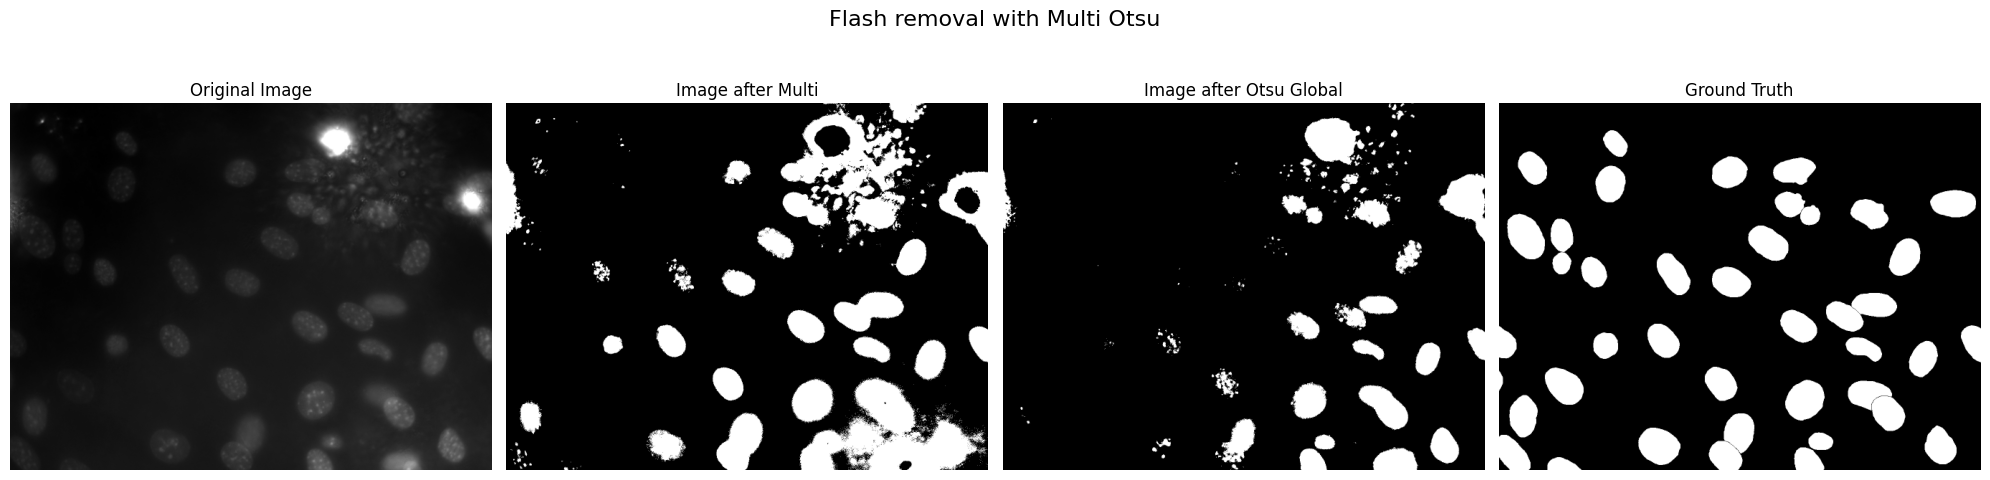

In [ ]:
from src.multi import apply_multiotsu_mask_class1_foreground


img_nih3t3_multi = apply_multiotsu_mask_class1_foreground(img_nih3t3).astype(int)
threshold_nih3t3_global = otsu_threshold_skimage_like(img_nih3t3)

img_nih3t3_otsu_global = (img_nih3t3 > threshold_nih3t3_global).astype(int)

plot_images_fixed_size(
    images=[img_nih3t3, img_nih3t3_multi,img_nih3t3_otsu_global, gt_nih3t3],
    titles=["Original Image", "Image after Multi", "Image after Otsu Global", "Ground Truth"],
    main_title = "Flash removal with Multi Otsu"
)

After generating the segmentations, we quantitatively evaluate the Multi-Otsu approach on the entire NIH3T3 dataset by computing Dice scores for all images. We plot these Dice scores against those obtained from our global Otsu implementation using a scatter plot. Points are colored to indicate whether Multi-Otsu performed better (green), worse (red), or similarly (blue) compared to global Otsu thresholding.

The results showed that Multi-Otsu thresholding did not lead to consistent improvements; in many cases, it even degraded the segmentation performance due to misclassification of true nuclei pixels as background when intensities overlapped with those of artifacts. Based on these findings, we decided not to pursue the Multi-Otsu approach further in our project, as it did not reliably enhance segmentation quality on our data.

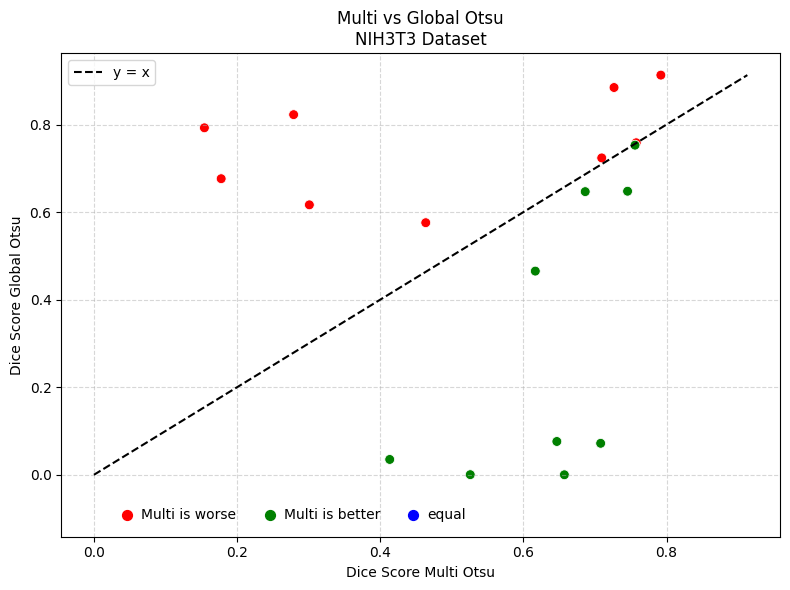

In [ ]:
from src.Plots import scatterplot_without_regression
from src.multi import calculate_multiotsu_dice_scores

dice_all_nih_multi = calculate_multiotsu_dice_scores(imgs_NIH3T3, gts_NIH3T3)

scatterplot_without_regression(
    dice_all_nih_multi,
    dice_all_nih_global,
    xlabel="Dice Score Multi Otsu",
    ylabel="Dice Score Global Otsu",
    title="Multi vs Global Otsu\nNIH3T3 Dataset",
    label_red = "Multi is worse",
    label_green = "Multi is better",
    label_blue = "equal"
)